In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from ase import Atoms, io
from ase.build import molecule, bulk
from ase.quaternions import Quaternion
from muspinsim.spinsys import SpinSystem, MuonSpinSystem
from muspinsim.spinop import DensityOperator
from muspinsim.experiment import MuonExperiment
from muspinsim.constants import MU_GAMMA
from soprano.nmr.utils import _dip_constant, _dip_tensor
from soprano.data.nmr import (_get_isotope_data, _get_nmr_data, _el_iso)
from soprano.utils import periodic_bridson
from soprano.properties.nmr.dipolar import DipolarRSS, DipolarTensor, DipolarCoupling

In [3]:
gH = _get_isotope_data('H', 'gamma')

r = np.array([1.,1,0])
d = _dip_constant(np.linalg.norm(r)*1e-10, gH, gH)

a = np.array([1.,0,0])
n = 100
q = Quaternion.from_axis_angle(a, 2*np.pi/n)

dtens = [_dip_tensor(d, r)]
for i in range(n-1):
    r = q.rotate(r)
    dtens.append(_dip_tensor(d, r))
    
print(np.average(dtens, axis=0))
print(_dip_tensor(d, r, a))

[[-2.12344357e+04  1.46974344e-11  7.38964445e-12]
 [ 1.65891834e-11  1.06172179e+04  2.59706212e-11]
 [ 1.19052856e-11  2.66254574e-11  1.06172179e+04]]
[[-21234.43571489     -0.             -0.        ]
 [    -0.          10617.21785744     -0.        ]
 [    -0.             -0.          10617.21785744]]


In [87]:
# Z = 3
# cell = np.eye(3)*10

# h2 = molecule('H2')
# h2p = h2.get_positions()
# # Build it as H2 molecules
# cgen = periodic_bridson(cell*0.5, 1.5)
# centers = np.array([next(cgen) for i in range(Z)])
# positions = (h2p[:,None,:]+centers[None,:,:]).reshape((-1,3))

# positions = np.random.normal(size=(2*Z,3))
# positions *= 0.9/np.linalg.norm(positions, axis=1)[:,None]

# Build a random walk of hydrogen
r = 0.9
n = 8
pos = np.array([[0,0,0], [0, 0, r]])
for i in range(1,n-1):
    d01 = pos[i]-pos[i-1]
    d12 = -d01.copy()
    while np.dot(d01, d12) < 0:
        d12 = np.random.normal(size=3)
        d12 *= r/np.linalg.norm(d12)
    pos = np.concatenate([pos, [pos[i]+d12]])
        
a = Atoms(['H']*n, cell=cell, positions=pos+[5,5,5])
io.write('Hdip.cif', a)

# h2o = molecule('H2O')
# h2o.set_cell(np.eye(3)*10)
# elems = np.array(h2o.get_chemical_symbols())
# a = h2o[np.where(elems == 'H')[0]]

#io.write('H2O.cif', h2o)

In [89]:
1e-3*np.average(DipolarRSS.get(a)**2)**0.5

453.07591310268333

In [83]:
459.3575773308919/115.391

3.980878728244767

In [84]:
DipolarRSS.get(a)*1e-3

array([172.75873801, 240.11354652, 237.5502717 , 248.49218637,
       237.27196017, 244.06037214, 235.04131014, 169.65790324])

In [85]:
ssys = SpinSystem(a.get_chemical_symbols())
B = 5.0
for i in range(len(ssys)):
    ssys.add_linear_term(i, np.array([0, 0, B])*ssys.gamma(i))
    for j in range(i+1, len(ssys)):
        ssys.add_bilinear_term(i, j, DipolarTensor.get(a)[(i,j)]*1e-6)

H = ssys.hamiltonian
Sxtot = sum([ssys.operator({i: 'x'}) for i in range(len(ssys))], 0*ssys.operator({}))
print(np.abs(np.trace(((H*Sxtot-Sxtot*H)*(H*Sxtot-Sxtot*H)).matrix)/np.trace((Sxtot*Sxtot).matrix)))

45321.09226636035


In [86]:
evals, evecs = H.diag()
Sxdiag = Sxtot.basis_change(evecs)

freqs = (evals[:,None]-evals[None,:]).reshape((-1,))
weights = np.abs(Sxdiag.matrix.T.reshape((-1,)))

# Central?
larmor = B*ssys.gamma(0)
# Which ones are close enough?
peak_inds = np.where((abs(freqs-larmor) < 0.5*larmor)*(1-np.isclose(weights, 0)))

rss = (np.sum(weights[peak_inds]**2*(freqs[peak_inds]-larmor)**2)/np.sum(weights[peak_inds]**2))**0.5
nu2 = (np.sum(weights**2*(freqs)**2)/np.sum(weights**2))
print("RSS: {0:.3f} kHz".format(rss*1e3))
print("<\\nu^2> = {0:.3f} kHz".format(nu2))

RSS: 177.741 kHz
<\nu^2> = 45321.092 kHz


In [53]:
print(1e-3*np.average(DipolarRSS.get(a)**2)**0.5, rss*1e3)

222.58902171979997 182.87551750814157


<IPython.core.display.Javascript object>


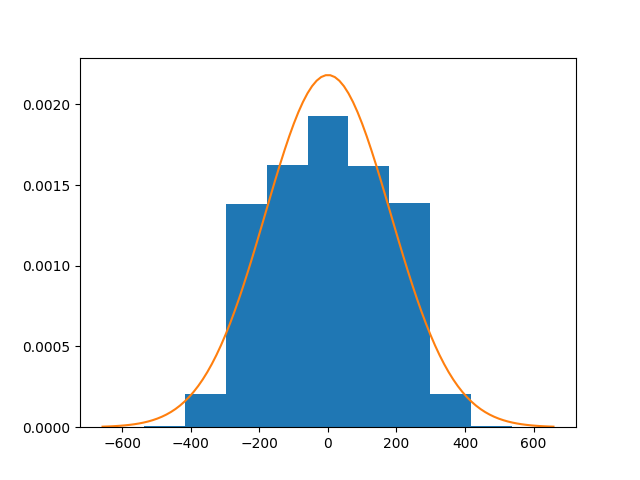

In [54]:
fig, ax = plt.subplots()

ax.hist((freqs[peak_inds]-larmor)*1e3, weights=abs(weights[peak_inds]), bins=11, density=True)
f = (np.linspace(min(freqs[peak_inds]), max(freqs[peak_inds]), 100)-larmor)*1e3

ax.plot(f, np.exp(-f**2/(2*(rss*1e3)**2))/(2e6*np.pi*rss**2)**0.5)

In [ ]:
9/4*209.465

In [56]:
ssys = MuonSpinSystem(['mu', 'H', 'H'])
r = 0.74
dterm = ssys.add_dipolar_term(1,2,[0,0,r])

print(dterm.tensor*1e3)

[[ 296.42890823    0.            0.        ]
 [   0.          296.42890823    0.        ]
 [   0.            0.         -592.85781646]]


In [58]:
print(DipolarTensor.get(Atoms('HH', positions=[[0,0,0],[0,0,r]]))[(0,1)]*1e-3)

[[ 296.42890823   -0.           -0.        ]
 [  -0.          296.42890823   -0.        ]
 [  -0.           -0.         -592.85781646]]


In [14]:
muexp = MuonExperiment(['mu', 'F', 'F'])
rF = np.array([0.5**0.5, 0.5**0.5, 0])*1.17
dt1 = muexp.spin_system.add_dipolar_term(0, 1, rF)
dt2 = muexp.spin_system.add_dipolar_term(0, 2, -rF)
#dt3 = muexp.spin_system.add_dipolar_term(1, 2, 2*rF)

D = min(abs(np.linalg.eigh(dt2.tensor)[0]))
#muexp.set_magnetic_field(220*1e-4)

print(D)

0.22473126376639396


In [23]:
rF

array([0.82731493, 0.82731493, 0.        ])

In [22]:
muFF = Atoms(['H', 'F', 'F'], positions=[[0, 0, 0], rF, -rF])

print(DipolarCoupling.get(muFF)[(0,1)][0]*2*np.pi)
(DipolarTensor.get(muFF)[(0,1)]*3.18334585)*1e-6

-443567.3159774677


array([[-0.11236563, -0.3370969 , -0.        ],
       [-0.3370969 , -0.11236563, -0.        ],
       [-0.        , -0.        ,  0.22473126]])

In [6]:
dt1.tensor

array([[-0.11236563, -0.3370969 ,  0.        ],
       [-0.3370969 , -0.11236563,  0.        ],
       [ 0.        ,  0.        ,  0.22473126]])

In [7]:
t = np.linspace(0, 7, 1000)
evol = muexp.run_experiment(t)['e']

In [8]:
import csv

reader = csv.reader(open('NaFmuon.csv'))
muNaFdata = np.array([list(map(float, l)) for l in reader])

<IPython.core.display.Javascript object>


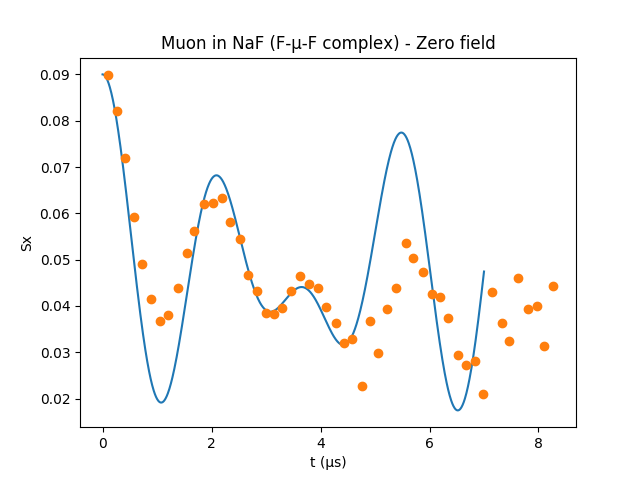

In [13]:
fig, ax = plt.subplots()

ax.set_title('Muon in NaF (F-μ-F complex) - Zero field')
ax.set_xlabel('t (μs)')
ax.set_ylabel('Sx')
ax.plot(t, evol[:,0]*0.09*2)
ax.plot(muNaFdata[:,0], muNaFdata[:,1], 'o')
#ax.plot(t, 0.5*np.cos(2*np.pi*D*t))

In [ ]:
8.5137e4*1e-6/(2*np.pi)

In [ ]:
220*1e-4*muexp.spin_system.gamma(0)

In [ ]:
muexp.spin_system.gamma(0)

In [61]:
_dip_constant(r*1e-10, gH, gH)*1e-3

array([-296.42890823])

In [143]:
(MU_GAMMA*2*np.pi*1e6/gH)

array([3.18334585])

851615455.9811571